In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import copy
import torch
from abc_env_stoch import ABCflow
from abc_env_stoch_gym import ABCflow_gym
from naive_agents import DoNothing, FixedPhi
from stable_baselines3 import A2C, PPO
#from dynamic_phi_agent import DynamicPhiAgent
from dynamic_phi_actor_physicists_mean_var import DynamicPhiAgent


In [35]:
def compare_agents(agent_list,identfiers, sep_size=0.02*np.pi,num_eps=100,time_horizon=25):
    label_index=0
    labels=[]
    
    for agent in agent_list:
        env = ABCflow(sep_size)
        cum_rew=np.zeros(int(env.limit/env.deltaT)+1)
        for i in range(0,num_eps):
            time_step=0
            episode_rew=0
            while not env.isOver():
                action=agent.sample_action(env.getState())
                reward = env.step(action)
                episode_rew += reward
                cum_rew[time_step] += episode_rew
                time_step += 1
            env.reset()
        plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps)
        labels.append(identfiers[label_index])
        label_index+=1
        
    """
    
    env = ABCflow_gym(sep_size)
    model = A2C('MlpPolicy', env, verbose=False)
    model.load("saved_models/A2C")
    
    cum_rew=np.zeros(int(env.limit/env.deltaT)+1)
    for ep in range(num_eps):

        obs = env.reset()
        done = False
        time_step=0
        episode_rew=0
        while not done:
            action, _states = model.predict(obs)
            #print(action)
            obs, reward, done, info = env.step(action)
            #rewards.append(reward)
            episode_rew += reward
            cum_rew[time_step] += episode_rew
            time_step+=1
    plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps)
    labels.append("A2C")
    
    
    
    env = ABCflow_gym(sep_size)
    model = PPO('MlpPolicy', env, verbose=False)
    model.load("saved_models/PPO")
    
    cum_rew=np.zeros(int(env.limit/env.deltaT)+1)
    for ep in range(num_eps):

        obs = env.reset()
        done = False
        time_step=0
        episode_rew=0
        while not done:
            action, _states = model.predict(obs)
            #print(action)
            obs, reward, done, info = env.step(action)
            #rewards.append(reward)
            episode_rew += reward
            cum_rew[time_step] += episode_rew
            time_step+=1
    plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps)
    labels.append("PPO")
    """
    
        
    plt.legend(labels)
    plt.title(f"Avg Cumalative Reward")
    plt.xlabel("episode time")
    plt.ylabel("reward")
    


def compare_agents_distances(agent_list,identfiers, sep_size=0.02*np.pi, num_eps=100):
    label_index=0
    labels=[]
    
    for agent in agent_list:
        env = ABCflow(sep_size)
        cum_dist=np.zeros(int(env.limit/env.deltaT)+1)
        for i in range(0,num_eps):
            time_step=0
            while not env.isOver():
                action=agent.sample_action(env.getState())
                env.step(action)
                cum_dist[time_step] += env.dist()
                time_step += 1
            env.reset()
        plt.plot(np.arange(len(cum_dist))/(1/env.deltaT),cum_dist/num_eps)
        labels.append(identfiers[label_index])
        label_index+=1
    plt.legend(labels)

    
    
def plot_agent_trajectory(agent, sep_size=0.02*np.pi, seed=1):
    env = ABCflow(sep_size, seed=seed)
#    print(env.passive)
#    print(env.active)
    active = np.array([]).reshape(0, 3)
    passive = np.array([]).reshape(0, 3)
    
    while not env.isOver():
        active = np.vstack((active, env.active))
        passive = np.vstack((passive, env.passive))
        state = env.getState()
        action = agent.sample_action(state)
        env.step(action)
    
    fig = go.Figure(data=go.Scatter3d(
        x=passive[:,0],
        y=passive[:,1],
        z=passive[:,2],
        mode='lines',
        name = "passive"
      )
    )
    
    fig.add_trace(go.Scatter3d(
        x=active[:,0],
        y=active[:,1],
        z=active[:,2],
        mode='lines',
        name = "active"
      )
    )
#    print(env.passive)
#    print(env.active)
    fig.show()
    
def plot_phis(agent, sep_size=0.02*np.pi, seed=1):
    env = ABCflow(sep_size, seed=seed)
    phis=[]
    while not env.isOver():
        state = env.getState()
        action = agent.sample_action(state)
        phi = (action @ state) / (state @ state)
        env.step(action)
        phis.append(phi)
        
        
    window_size = 100
    avg_phis = []

    # Calculate sliding window averages
    for i in range(len(phis) - window_size + 1):
        window = phis[i : i + window_size]
        window_avg = np.mean(window)
        avg_phis.append(window_avg)
    
    
    plt.plot(avg_phis)

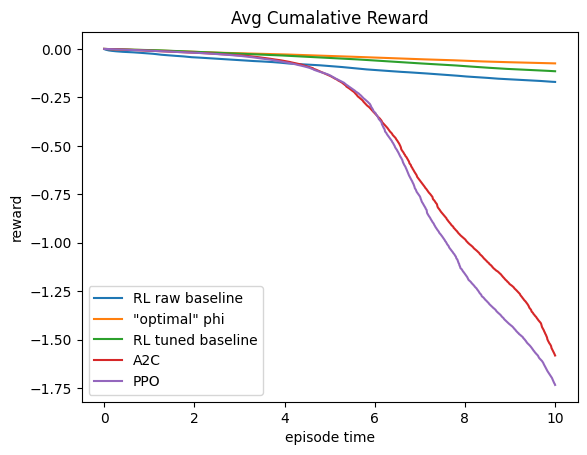

In [38]:
#do_nothing = DoNothing()
#phi_val=0.75
#moderate_phi = FixedPhi(.7)
hand_tuned_phi = FixedPhi(1.1)
fixedhigh = FixedPhi(2.7)
trained = DynamicPhiAgent(action_scale=5.)
trained_optimal = DynamicPhiAgent(action_scale=5.)
trained.load_policy("saved_models/phi_only_0.7_untuned.pt")
trained_optimal.load_policy("saved_models/phi_only_0.7.pt")
compare_agents([trained ,hand_tuned_phi,trained_optimal],#,fixedhigh],
              ["RL raw baseline","\"optimal\" phi","RL tuned baseline"],#"phi=2.7"],
              num_eps=10)

#compare_agents([hand_tuned_phi],#,fixedhigh],
#              ["\"optimal\" phi"],
#              num_eps=10)

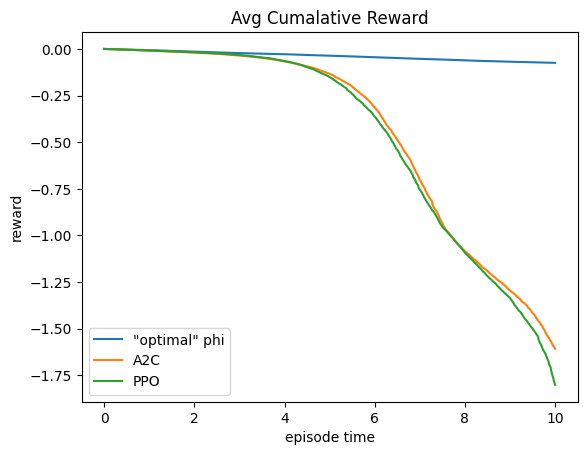

In [39]:
compare_agents([hand_tuned_phi],#,fixedhigh],
              ["\"optimal\" phi"],
              num_eps=10)

In [ ]:
#do_nothing = DoNothing()
moderate_phi = FixedPhi(0.5)
hand_tuned_phi = FixedPhi(1.1)
fixedhigh = FixedPhi(2.7)
trained = DynamicPhiAgent(action_scale=5.)
trained_optimal = DynamicPhiAgent(action_scale=5.)
trained.load_policy("saved_models/phi_only_0.5.pt")
trained_optimal.load_policy("saved_models/phi_only_1.1.pt")
compare_agents([moderate_phi, trained ,hand_tuned_phi,trained_optimal],#,fixedhigh],
              ["phi=0.5","trained_with_baseline_0.5","hand_tuned_phi","trained_optimal_baseline"],#"phi=2.7"],
               #1,
              num_eps=10)

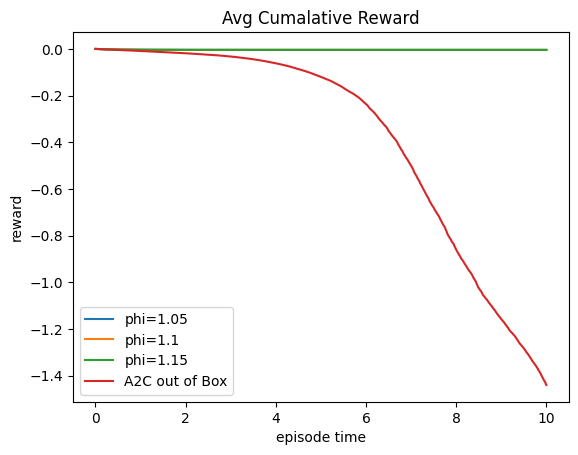

In [5]:
start=105
end=120
agents = [FixedPhi(i/100) for i in range(start,end,5)]
compare_agents(agents, [f"phi={i/100}" for i in range(start,end,5)],num_eps=20)

In [6]:
for i in range(100,120,5):
    print(i)

100
105
110
115


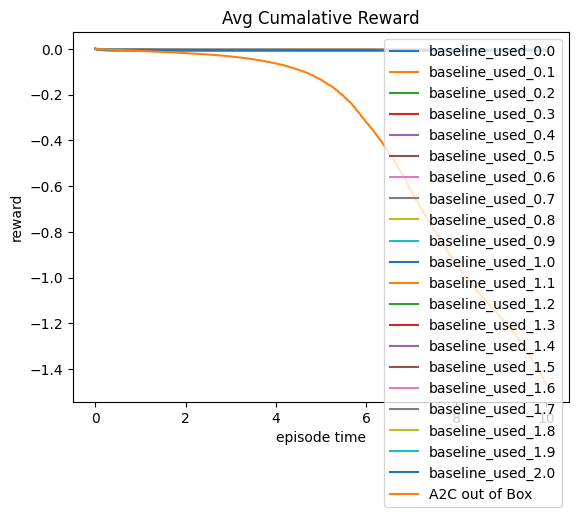

In [7]:
agents = [DynamicPhiAgent(action_scale=5.) for i in range(0,21)]
for i in range(0,21):
    agents[i].load_policy(f"saved_models/phi_only_{i/10}.pt")
compare_agents(agents, [f"baseline_used_{i/10}" for i in range(0,21)],num_eps=20)

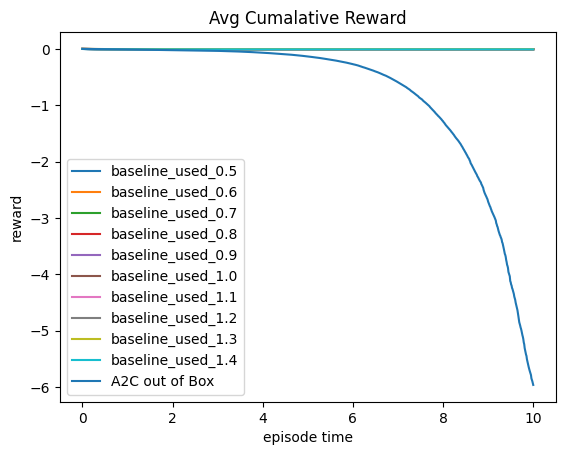

In [8]:
start=5
end=15
agents = [DynamicPhiAgent(action_scale=5.) for i in range(start,end)]
for i in range(end-start):
    agents[i].load_policy(f"saved_models/phi_only_{i/10}.pt")
compare_agents(agents, [f"baseline_used_{i/10}" for i in range(start,end)],num_eps=50)

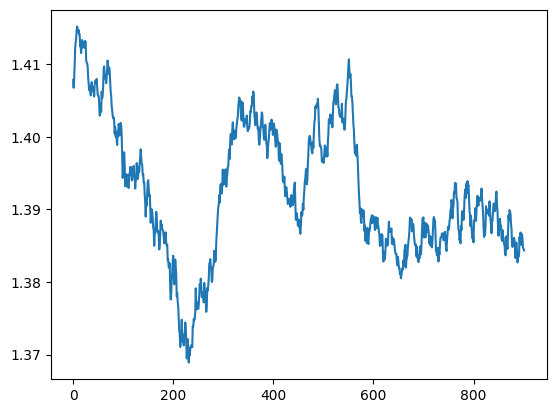

In [9]:
plot_phis(trained,seed=1)

In [10]:
plot_phis(mean_plus_var,seed=1)

NameError: name 'mean_plus_var' is not defined

In [ ]:
compare_agents_distances([moderate_phi,hand_tuned_phi,trained],
              ["moderate_phi","hand_tuned_phi","trained_doofus"],
               1,
              num_eps=20)

In [ ]:
for i in range(0,10):
    print(i/10)

In [ ]:
plot_agent_trajectory(moderate_phi,seed=2)

In [ ]:
plot_agent_trajectory(untrained,seed=10)

In [ ]:
compare_agents_distances([untrained,do_nothing,moderate_phi],
              ["untrained","do_nothing","moderate_phi"],
              num_eps=20)

In [ ]:
#TODOs
"""
General todos. 
Create an RL only actor critic agent
Create an RL assisted actor critic agent (same class just an optional base action function?)
Create a dynamic phi tuning actor critic agent
    - application to guarentee a  lower bound on performance?
    - Future research PID dynamic coeffcients?
Then create both learns phi dynamically plus learns the correction`
    

"""

In [ ]:
import torch
torch.distributions.Normal

In [ ]:
a=torch.distributions.Normal(0,1.)

In [ ]:
a.log_prob(torch.tensor([2]))

In [ ]:
do_nothing = DoNothing()
weak = FixedPhi(0.1)
super_weak = FixedPhi(0.01)
compare_agents([do_nothing,weak,super_weak],
              ["do_nothing","weak","super_weak"],
              num_eps=20)

In [ ]:
means=torch.tensor([1.0,0.0]).view(-1,1)
stds=torch.tensor([1.0,3.0]).view(-1,1)

m = torch.distributions.Normal(means[:,0], stds[:,0])
samples = m.sample().view(-1,1)  # normally distributed with loc=0 and scale=1
print(samples.size())
m.log_prob(samples)

In [ ]:
means[:,0].size()

In [ ]:
env = ABCflow(a=0.,b=0.,c=0.)
env.limit=2.
#env.reset()
while not env.isOver():
    env.step(-env.getState())
print(np.linalg.norm(env.getState()))

In [ ]:
np.exp(np.array([[1.],
                [2.]]))

In [ ]:
x = np.empty((0,3),float)
for i in range(10):
    x = np.vstack((x,np.random.rand(3)))
x

In [ ]:
x.shape

In [11]:
max([1,2,3])

3

In [5]:
for i in range(0,1):
    print(i)

0
